# Cross-Dataset Comparison: CKB vs ARIC

This notebook compares imputation performance across two datasets (CKB and ARIC) using two methods (VAE and WNN).
The analysis focuses on the difference in correlation (Delta-R) to assess generalization performance.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Set plotting style
plt.style.use('seaborn-v0_8-whitegrid' if 'seaborn-v0_8-whitegrid' in plt.style.available else 'seaborn-whitegrid')
plt.rcParams.update({
    'font.family': 'Arial',
    'font.size': 12,
    'axes.labelsize': 14,
    'axes.titlesize': 16,
    'xtick.labelsize': 11,
    'ytick.labelsize': 11,
    'legend.fontsize': 11,
    'figure.titlesize': 18,
    'savefig.dpi': 300,
    'savefig.bbox': 'tight',
})

# Color scheme
colors = {
    'cpiVAE': '#e64b35',  # Red
    'WNN': '#4dbbd5',  # Blue
    'Olink-Somascan': 0.8,  # Darker shade multiplier
    'ARIC (S→O)': 1.0  # Lighter shade multiplier
}

## Configuration

Update these paths to match your data locations:

In [21]:
# Dataset configurations
# Olink-Somascan dataset (cross-platform, uses compare_result.py)
ckb_config = {
    'truth_a': 'data/olink_overlap_test.csv',  # Olink platform
    'truth_b': 'data/somascan_overlap_test.csv',  # Somascan platform
    'imp_a_vae': 'data/olink_overlap_test_imputed_vae.csv',  # Method 1 = cpiVAE
    'imp_b_vae': 'data/somascan_overlap_test_imputed_vae.csv',
    'imp_a_wnn': 'data/olink_overlap_test_imputed_wnn.csv',  # Method 2 = WNN
    'imp_b_wnn': 'data/somascan_overlap_test_imputed_wnn.csv',
    'dataset_name': 'Olink-Somascan',
    'is_cross_platform': True,
    'transpose': True  # Data needs transposing
}

# ARIC dataset (single-platform, uses compare_result_oneplatform.py)
# S->O: Somascan to Olink imputation
aric_config = {
    'truth_a': 'data/NC_ARIC/olink_visit5_96_withGroups.csv',
    'imp_a_vae': 'data/NC_ARIC/olink_visit5_imputed_vae.csv',  # Method 1 = cpiVAE
    'imp_a_wnn': 'data/NC_ARIC/olink_visit5_imputed_wnn.csv',  # Method 2 = WNN
    'dataset_name': 'ARIC (S→O)',
    'is_cross_platform': False,
    'transpose': True  # Data needs transposing
}

# Method names
method1_name = 'cpiVAE'
method2_name = 'WNN'

## Helper Functions

In [22]:
def load_data(file_path, transpose=False):
    """Load CSV data with automatic orientation detection"""
    df = pd.read_csv(file_path, index_col=0)
    
    # Apply transpose if specified
    if transpose:
        print(f"  Transposing {file_path}")
        df = df.T
    
    # Convert to numeric, replacing non-numeric values with NaN
    df = df.apply(pd.to_numeric, errors='coerce')
    
    # Ensure features are rows, samples are columns
    # (This is already the expected format after transpose if needed)
    return df

def align_dataframes(truth, imputed):
    """Align truth and imputed dataframes to have matching indices and columns"""
    # Find common features (rows) and samples (columns)
    common_features = truth.index.intersection(imputed.index)
    common_samples = truth.columns.intersection(imputed.columns)
    
    if len(common_features) == 0:
        print(f"    Warning: No common features found between truth and imputed")
        # Try matching by position if indices don't match
        if truth.shape[0] == imputed.shape[0]:
            print(f"    Attempting to align by position (same number of features)")
            imputed.index = truth.index
            common_features = truth.index
        else:
            return None, None
    
    if len(common_samples) == 0:
        print(f"    Warning: No common samples found between truth and imputed")
        # Try matching by position if columns don't match
        if truth.shape[1] == imputed.shape[1]:
            print(f"    Attempting to align by position (same number of samples)")
            imputed.columns = truth.columns
            common_samples = truth.columns
        else:
            return None, None
    
    # Subset to common features and samples
    truth_aligned = truth.loc[common_features, common_samples]
    imputed_aligned = imputed.loc[common_features, common_samples]
    
    return truth_aligned, imputed_aligned

def compute_feature_wise_correlations(truth, imputed, method_name):
    """Compute feature-wise correlations between truth and imputed data"""
    correlations = []
    
    # Align dataframes first
    truth_aligned, imputed_aligned = align_dataframes(truth, imputed)
    if truth_aligned is None:
        print(f"    Error: Could not align truth and imputed data for {method_name}")
        return pd.DataFrame()
    
    print(f"    Aligned shapes - Truth: {truth_aligned.shape}, Imputed: {imputed_aligned.shape}")
    
    for feature in truth_aligned.index:
        truth_vals = truth_aligned.loc[feature].values.astype(float)
        imp_vals = imputed_aligned.loc[feature].values.astype(float)
        
        # Remove NaN values
        mask = ~(np.isnan(truth_vals) | np.isnan(imp_vals))
        if np.sum(mask) < 3:  # Need at least 3 points
            continue
            
        truth_clean = truth_vals[mask]
        imp_clean = imp_vals[mask]
        
        # Skip if no variation
        if np.std(truth_clean) == 0 or np.std(imp_clean) == 0:
            continue
        
        # Compute correlation
        try:
            r, _ = pearsonr(truth_clean, imp_clean)
            if not np.isnan(r):
                correlations.append({
                    'feature': feature,
                    'method': method_name,
                    'r': r,
                    'n_samples': np.sum(mask)
                })
        except:
            continue
    
    return pd.DataFrame(correlations)

def compute_sample_wise_correlations(truth, imputed, method_name):
    """Compute sample-wise correlations between truth and imputed data"""
    correlations = []
    
    # Align dataframes first
    truth_aligned, imputed_aligned = align_dataframes(truth, imputed)
    if truth_aligned is None:
        print(f"    Error: Could not align truth and imputed data for {method_name}")
        return pd.DataFrame()
    
    for sample in truth_aligned.columns:
        truth_vals = truth_aligned[sample].values.astype(float)
        imp_vals = imputed_aligned[sample].values.astype(float)
        
        # Remove NaN values
        mask = ~(np.isnan(truth_vals) | np.isnan(imp_vals))
        if np.sum(mask) < 3:  # Need at least 3 points
            continue
            
        truth_clean = truth_vals[mask]
        imp_clean = imp_vals[mask]
        
        # Skip if no variation
        if np.std(truth_clean) == 0 or np.std(imp_clean) == 0:
            continue
        
        # Compute correlation
        try:
            r, _ = pearsonr(truth_clean, imp_clean)
            if not np.isnan(r):
                correlations.append({
                    'sample': sample,
                    'method': method_name,
                    'r': r,
                    'n_features': np.sum(mask)
                })
        except:
            continue
    
    return pd.DataFrame(correlations)

def process_dataset(config, method1_name, method2_name):
    """Process a single dataset and compute metrics for both methods"""
    print(f"\nProcessing {config['dataset_name']} dataset...")
    
    results = {
        'dataset': config['dataset_name'],
        'feature_wise': {},
        'sample_wise': {}
    }
    
    # Get transpose flag if exists
    transpose = config.get('transpose', False)
    
    # Load data
    truth_a = load_data(config['truth_a'], transpose)
    imp_a_m1 = load_data(config['imp_a_vae'], transpose)
    imp_a_m2 = load_data(config['imp_a_wnn'], transpose)
    
    print(f"  Truth shape: {truth_a.shape} (features x samples)")
    print(f"  Imputed {method1_name} shape: {imp_a_m1.shape}")
    print(f"  Imputed {method2_name} shape: {imp_a_m2.shape}")
    
    # Check if dimensions suggest we need additional transpose
    if truth_a.shape[0] != imp_a_m1.shape[0] and truth_a.shape[1] == imp_a_m1.shape[0]:
        print(f"  Auto-transposing imputed data to match truth dimensions")
        imp_a_m1 = imp_a_m1.T
        imp_a_m2 = imp_a_m2.T
        print(f"  After transpose - {method1_name}: {imp_a_m1.shape}, {method2_name}: {imp_a_m2.shape}")
    
    # For cross-platform datasets, also load platform B
    if config['is_cross_platform']:
        truth_b = load_data(config['truth_b'], transpose)
        imp_b_m1 = load_data(config['imp_b_vae'], transpose)
        imp_b_m2 = load_data(config['imp_b_wnn'], transpose)
        print(f"  Platform B Truth shape: {truth_b.shape}")
        
        # Check if dimensions suggest we need additional transpose
        if truth_b.shape[0] != imp_b_m1.shape[0] and truth_b.shape[1] == imp_b_m1.shape[0]:
            print(f"  Auto-transposing Platform B imputed data to match truth dimensions")
            imp_b_m1 = imp_b_m1.T
            imp_b_m2 = imp_b_m2.T
    
    # Compute feature-wise correlations
    print("  Computing feature-wise correlations...")
    feat_m1_a = compute_feature_wise_correlations(truth_a, imp_a_m1, method1_name)
    feat_m2_a = compute_feature_wise_correlations(truth_a, imp_a_m2, method2_name)
    
    if config['is_cross_platform']:
        feat_m1_b = compute_feature_wise_correlations(truth_b, imp_b_m1, method1_name)
        feat_m2_b = compute_feature_wise_correlations(truth_b, imp_b_m2, method2_name)
        
        # Combine both platforms
        feat_m1 = pd.concat([feat_m1_a, feat_m1_b], ignore_index=True)
        feat_m2 = pd.concat([feat_m2_a, feat_m2_b], ignore_index=True)
    else:
        feat_m1 = feat_m1_a
        feat_m2 = feat_m2_a
    
    # Compute sample-wise correlations
    print("  Computing sample-wise correlations...")
    samp_m1_a = compute_sample_wise_correlations(truth_a, imp_a_m1, method1_name)
    samp_m2_a = compute_sample_wise_correlations(truth_a, imp_a_m2, method2_name)
    
    if config['is_cross_platform']:
        samp_m1_b = compute_sample_wise_correlations(truth_b, imp_b_m1, method1_name)
        samp_m2_b = compute_sample_wise_correlations(truth_b, imp_b_m2, method2_name)
        
        # Combine both platforms
        samp_m1 = pd.concat([samp_m1_a, samp_m1_b], ignore_index=True)
        samp_m2 = pd.concat([samp_m2_a, samp_m2_b], ignore_index=True)
    else:
        samp_m1 = samp_m1_a
        samp_m2 = samp_m2_a
    
    # Check if we have data
    if feat_m1.empty or feat_m2.empty:
        print(f"  Warning: No valid feature-wise correlations found")
        results['feature_wise'][method1_name] = np.nan
        results['feature_wise'][method2_name] = np.nan
        results['feature_wise']['delta_r'] = np.nan
    else:
        # Store results
        results['feature_wise'][method1_name] = feat_m1['r'].mean()
        results['feature_wise'][method2_name] = feat_m2['r'].mean()
        results['feature_wise']['delta_r'] = results['feature_wise'][method1_name] - results['feature_wise'][method2_name]
        
        print(f"  Feature-wise: {method1_name}={results['feature_wise'][method1_name]:.3f} (n={len(feat_m1)}), "
              f"{method2_name}={results['feature_wise'][method2_name]:.3f} (n={len(feat_m2)}), "
              f"Delta-R={results['feature_wise']['delta_r']:.3f}")
    
    if samp_m1.empty or samp_m2.empty:
        print(f"  Warning: No valid sample-wise correlations found")
        results['sample_wise'][method1_name] = np.nan
        results['sample_wise'][method2_name] = np.nan
        results['sample_wise']['delta_r'] = np.nan
    else:
        results['sample_wise'][method1_name] = samp_m1['r'].mean()
        results['sample_wise'][method2_name] = samp_m2['r'].mean()
        results['sample_wise']['delta_r'] = results['sample_wise'][method1_name] - results['sample_wise'][method2_name]
        
        print(f"  Sample-wise: {method1_name}={results['sample_wise'][method1_name]:.3f} (n={len(samp_m1)}), "
              f"{method2_name}={results['sample_wise'][method2_name]:.3f} (n={len(samp_m2)}), "
              f"Delta-R={results['sample_wise']['delta_r']:.3f}")
    
    # Store detailed data for further analysis
    results['feature_wise_detailed'] = {'m1': feat_m1, 'm2': feat_m2}
    results['sample_wise_detailed'] = {'m1': samp_m1, 'm2': samp_m2}
    
    return results

## Process Both Datasets

In [23]:
# Process both datasets
ckb_results = process_dataset(ckb_config, method1_name, method2_name)
aric_results = process_dataset(aric_config, method1_name, method2_name)

# Print comparison
print("\n" + "="*60)
print("Generalization Comparison (Delta-R Analysis)")
print("="*60)
print(f"\nFeature-wise Delta-R:")
print(f"  Olink-Somascan: {ckb_results['feature_wise']['delta_r']:.3f}")
print(f"  ARIC (S→O):    {aric_results['feature_wise']['delta_r']:.3f}")
print(f"  Difference (ARIC - Olink-Somascan): {aric_results['feature_wise']['delta_r'] - ckb_results['feature_wise']['delta_r']:.3f}")

print(f"\nSample-wise Delta-R:")
print(f"  Olink-Somascan: {ckb_results['sample_wise']['delta_r']:.3f}")
print(f"  ARIC (S→O):    {aric_results['sample_wise']['delta_r']:.3f}")
print(f"  Difference (ARIC - Olink-Somascan): {aric_results['sample_wise']['delta_r'] - ckb_results['sample_wise']['delta_r']:.3f}")

if aric_results['feature_wise']['delta_r'] > ckb_results['feature_wise']['delta_r']:
    print("\n✓ cpiVAE shows better generalization on ARIC (feature-wise)")
else:
    print("\n✓ cpiVAE shows better generalization on Olink-Somascan (feature-wise)")
    
if aric_results['sample_wise']['delta_r'] > ckb_results['sample_wise']['delta_r']:
    print("✓ cpiVAE shows better generalization on ARIC (sample-wise)")
else:
    print("✓ cpiVAE shows better generalization on Olink-Somascan (sample-wise)")


Processing Olink-Somascan dataset...
  Transposing data/olink_overlap_test.csv
  Transposing data/olink_overlap_test_imputed_vae.csv
  Transposing data/olink_overlap_test_imputed_wnn.csv
  Truth shape: (2168, 796) (features x samples)
  Imputed cpiVAE shape: (2168, 796)
  Imputed WNN shape: (2168, 796)
  Transposing data/somascan_overlap_test.csv
  Transposing data/somascan_overlap_test_imputed_vae.csv
  Transposing data/somascan_overlap_test_imputed_wnn.csv
  Platform B Truth shape: (2731, 796)
  Computing feature-wise correlations...
    Aligned shapes - Truth: (2168, 796), Imputed: (2168, 796)
    Aligned shapes - Truth: (2168, 796), Imputed: (2168, 796)
    Aligned shapes - Truth: (2731, 796), Imputed: (2731, 796)
    Aligned shapes - Truth: (2731, 796), Imputed: (2731, 796)
  Computing sample-wise correlations...
  Feature-wise: cpiVAE=0.492 (n=4899), WNN=0.416 (n=4899), Delta-R=0.076
  Sample-wise: cpiVAE=0.508 (n=1592), WNN=0.416 (n=1592), Delta-R=0.092

Processing ARIC (S→O) d

## Create Comparison Figure

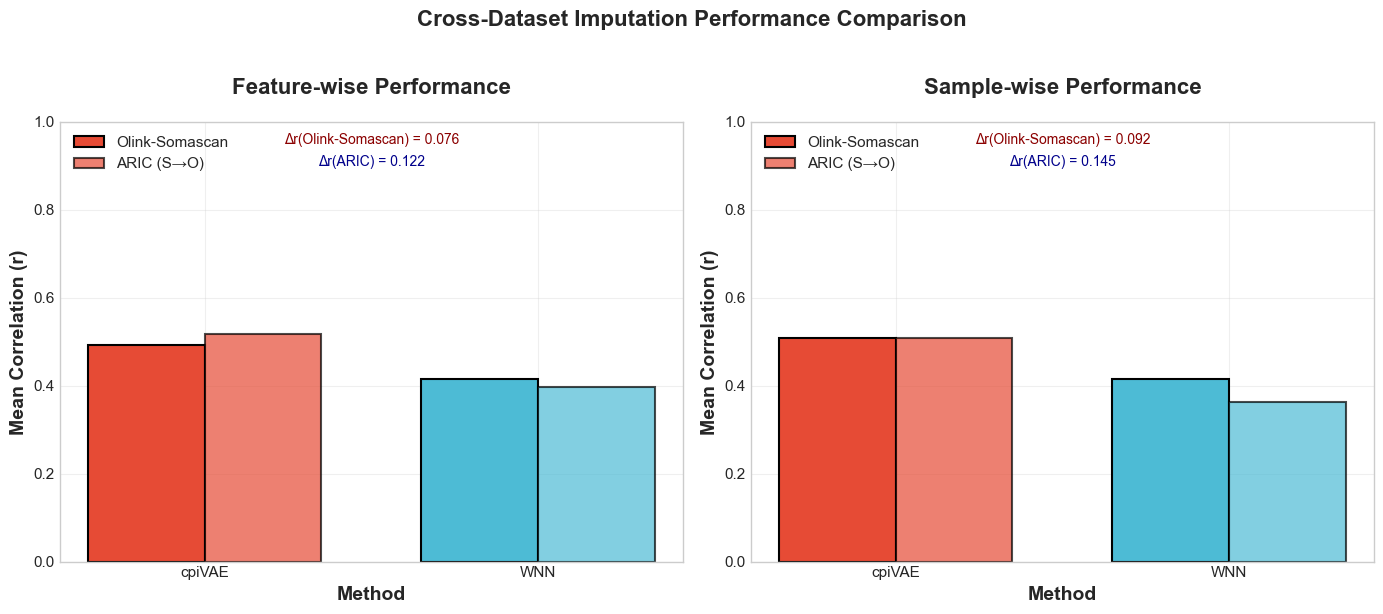

In [24]:
# Create the two-panel comparison figure
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Prepare data for plotting
datasets = ['Olink-Somascan', 'ARIC (S→O)']
methods = [method1_name, method2_name]

# Feature-wise comparison (left panel)
ax = axes[0]
x = np.arange(len(methods))
width = 0.35

# Olink-Somascan bars
ckb_values = [ckb_results['feature_wise'][m] for m in methods]
bars1 = ax.bar(x - width/2, ckb_values, width, label='Olink-Somascan',
               color=[colors[m] for m in methods],
               edgecolor='black', linewidth=1.5)

# ARIC bars
aric_values = [aric_results['feature_wise'][m] for m in methods]
bars2 = ax.bar(x + width/2, aric_values, width, label='ARIC (S→O)',
               color=[colors[m] for m in methods],
               edgecolor='black', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('Mean Correlation (r)', fontweight='bold')
ax.set_title('Feature-wise Performance', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Add Delta-R annotations
ax.text(0.5, 0.95, f'Δr(Olink-Somascan) = {ckb_results["feature_wise"]["delta_r"]:.3f}',
        transform=ax.transAxes, ha='center', fontsize=10, color='darkred')
ax.text(0.5, 0.90, f'Δr(ARIC) = {aric_results["feature_wise"]["delta_r"]:.3f}',
        transform=ax.transAxes, ha='center', fontsize=10, color='darkblue')

# Sample-wise comparison (right panel)
ax = axes[1]

# Olink-Somascan bars
ckb_values = [ckb_results['sample_wise'][m] for m in methods]
bars3 = ax.bar(x - width/2, ckb_values, width, label='Olink-Somascan',
               color=[colors[m] for m in methods],
               edgecolor='black', linewidth=1.5)

# ARIC bars
aric_values = [aric_results['sample_wise'][m] for m in methods]
bars4 = ax.bar(x + width/2, aric_values, width, label='ARIC (S→O)',
               color=[colors[m] for m in methods],
               edgecolor='black', linewidth=1.5, alpha=0.7)

ax.set_xlabel('Method', fontweight='bold')
ax.set_ylabel('Mean Correlation (r)', fontweight='bold')
ax.set_title('Sample-wise Performance', fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(methods)
ax.legend(loc='upper left')
ax.grid(True, alpha=0.3)
ax.set_ylim([0, 1])

# Add Delta-R annotations
ax.text(0.5, 0.95, f'Δr(Olink-Somascan) = {ckb_results["sample_wise"]["delta_r"]:.3f}',
        transform=ax.transAxes, ha='center', fontsize=10, color='darkred')
ax.text(0.5, 0.90, f'Δr(ARIC) = {aric_results["sample_wise"]["delta_r"]:.3f}',
        transform=ax.transAxes, ha='center', fontsize=10, color='darkblue')

plt.suptitle('Cross-Dataset Imputation Performance Comparison', fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Save figure
# fig.savefig('cross_dataset_comparison.png', dpi=300, bbox_inches='tight')

## Alternative Visualization: Grouped Bar Chart

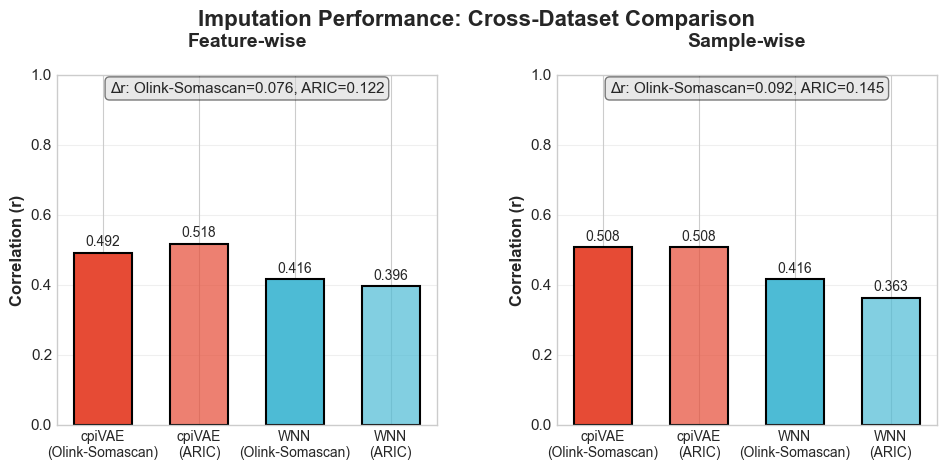

In [29]:
# Alternative visualization with cleaner grouping - Square 6x6 subplots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Make subplots square
for ax in axes:
    ax.set_aspect('auto')

# Prepare data
bar_data = {
    'Feature-wise': {
        f'{method1_name}-Olink-Somascan': ckb_results['feature_wise'][method1_name],
        f'{method1_name}-ARIC': aric_results['feature_wise'][method1_name],
        f'{method2_name}-Olink-Somascan': ckb_results['feature_wise'][method2_name],
        f'{method2_name}-ARIC': aric_results['feature_wise'][method2_name],
    },
    'Sample-wise': {
        f'{method1_name}-Olink-Somascan': ckb_results['sample_wise'][method1_name],
        f'{method1_name}-ARIC': aric_results['sample_wise'][method1_name],
        f'{method2_name}-Olink-Somascan': ckb_results['sample_wise'][method2_name],
        f'{method2_name}-ARIC': aric_results['sample_wise'][method2_name],
    }
}

for idx, (title, data) in enumerate(bar_data.items()):
    ax = axes[idx]
    
    labels = list(data.keys())
    values = list(data.values())
    
    # Color coding
    bar_colors = []
    for label in labels:
        if method1_name in label:
            base_color = colors[method1_name]
        else:
            base_color = colors[method2_name]
        
        if 'Olink-Somascan' in label:
            alpha = 1.0
        else:
            alpha = 0.7
        
        # Convert hex to RGBA
        from matplotlib.colors import to_rgba
        rgba = to_rgba(base_color)
        bar_colors.append((*rgba[:3], alpha))
    
    bars = ax.bar(range(len(labels)), values, color=bar_colors, 
                  edgecolor='black', linewidth=1.5, width=0.6)
    
    # Customize
    ax.set_xticks(range(len(labels)))
    ax.set_xticklabels([l.replace('-Olink-Somascan', '\n(Olink-Somascan)').replace('-ARIC', '\n(ARIC)') 
                        for l in labels], rotation=0, ha='center', fontsize=10)
    ax.set_ylabel('Correlation (r)', fontweight='bold', fontsize=12)
    ax.set_title(title, fontweight='bold', pad=20, fontsize=14)
    ax.set_ylim([0, 1])
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels on bars
    for bar, value in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{value:.3f}', ha='center', va='bottom', fontsize=10)
    
    # Add Delta-R comparison
    if idx == 0:
        delta_text = f"Δr: Olink-Somascan={ckb_results['feature_wise']['delta_r']:.3f}, ARIC={aric_results['feature_wise']['delta_r']:.3f}"
    else:
        delta_text = f"Δr: Olink-Somascan={ckb_results['sample_wise']['delta_r']:.3f}, ARIC={aric_results['sample_wise']['delta_r']:.3f}"
    
    ax.text(0.5, 0.95, delta_text, transform=ax.transAxes, 
            ha='center', fontsize=11, bbox=dict(boxstyle="round,pad=0.3", 
            facecolor='lightgray', alpha=0.5))
    
    # Make the plot area more square by adjusting spacing
    ax.set_position([0.08 + idx * 0.5, 0.15, 0.38, 0.7])

plt.suptitle('Imputation Performance: Cross-Dataset Comparison', 
             fontsize=16, fontweight='bold', y=0.98)

# Save figure
# fig.savefig('cross_dataset_comparison_grouped_square.png', dpi=300, bbox_inches='tight')
fig.savefig('/Users/sky2333/Downloads/cpiVAE/outputs_comparisons_vae_vs_rest_NC_ARIC/figures/figure_3c.pdf', dpi=300, bbox_inches='tight')

plt.show()

## Statistical Analysis

In [26]:
from scipy import stats

print("Statistical Comparison")
print("="*60)

# Feature-wise comparison
print("\nFeature-wise correlations:")

# Extract detailed correlations
ckb_vae_feat = ckb_results['feature_wise_detailed']['m1']['r'].values
ckb_wnn_feat = ckb_results['feature_wise_detailed']['m2']['r'].values
aric_vae_feat = aric_results['feature_wise_detailed']['m1']['r'].values
aric_wnn_feat = aric_results['feature_wise_detailed']['m2']['r'].values

# Paired t-tests within datasets
if len(ckb_vae_feat) == len(ckb_wnn_feat):
    t_stat, p_val = stats.ttest_rel(ckb_vae_feat, ckb_wnn_feat)
    print(f"  Olink-Somascan: {method1_name} vs {method2_name} - t={t_stat:.3f}, p={p_val:.4f}")
    
if len(aric_vae_feat) == len(aric_wnn_feat):
    t_stat, p_val = stats.ttest_rel(aric_vae_feat, aric_wnn_feat)
    print(f"  ARIC: {method1_name} vs {method2_name} - t={t_stat:.3f}, p={p_val:.4f}")

# Sample-wise comparison
print("\nSample-wise correlations:")

# Extract detailed correlations
ckb_vae_samp = ckb_results['sample_wise_detailed']['m1']['r'].values
ckb_wnn_samp = ckb_results['sample_wise_detailed']['m2']['r'].values
aric_vae_samp = aric_results['sample_wise_detailed']['m1']['r'].values
aric_wnn_samp = aric_results['sample_wise_detailed']['m2']['r'].values

# Paired t-tests within datasets
if len(ckb_vae_samp) == len(ckb_wnn_samp):
    t_stat, p_val = stats.ttest_rel(ckb_vae_samp, ckb_wnn_samp)
    print(f"  Olink-Somascan: {method1_name} vs {method2_name} - t={t_stat:.3f}, p={p_val:.4f}")
    
if len(aric_vae_samp) == len(aric_wnn_samp):
    t_stat, p_val = stats.ttest_rel(aric_vae_samp, aric_wnn_samp)
    print(f"  ARIC: {method1_name} vs {method2_name} - t={t_stat:.3f}, p={p_val:.4f}")

# Effect sizes (Cohen's d)
def cohens_d(x, y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.mean(x) - np.mean(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1)**2 + (ny-1)*np.std(y, ddof=1)**2) / dof)

print("\nEffect sizes (Cohen's d):")
print(f"  Feature-wise Olink-Somascan: {cohens_d(ckb_vae_feat, ckb_wnn_feat):.3f}")
print(f"  Feature-wise ARIC: {cohens_d(aric_vae_feat, aric_wnn_feat):.3f}")
print(f"  Sample-wise Olink-Somascan: {cohens_d(ckb_vae_samp, ckb_wnn_samp):.3f}")
print(f"  Sample-wise ARIC: {cohens_d(aric_vae_samp, aric_wnn_samp):.3f}")

Statistical Comparison

Feature-wise correlations:
  Olink-Somascan: cpiVAE vs WNN - t=73.593, p=0.0000
  ARIC: cpiVAE vs WNN - t=22.222, p=0.0000

Sample-wise correlations:
  Olink-Somascan: cpiVAE vs WNN - t=64.264, p=0.0000
  ARIC: cpiVAE vs WNN - t=42.067, p=0.0000

Effect sizes (Cohen's d):
  Feature-wise Olink-Somascan: 0.287
  Feature-wise ARIC: 0.574
  Sample-wise Olink-Somascan: 0.668
  Sample-wise ARIC: 1.139


## Export Results

In [27]:
# Create summary DataFrame
summary = pd.DataFrame({
    'Dataset': ['Olink-Somascan', 'Olink-Somascan', 'ARIC (S→O)', 'ARIC (S→O)'],
    'Method': [method1_name, method2_name, method1_name, method2_name],
    'Feature_wise_r': [
        ckb_results['feature_wise'][method1_name],
        ckb_results['feature_wise'][method2_name],
        aric_results['feature_wise'][method1_name],
        aric_results['feature_wise'][method2_name]
    ],
    'Sample_wise_r': [
        ckb_results['sample_wise'][method1_name],
        ckb_results['sample_wise'][method2_name],
        aric_results['sample_wise'][method1_name],
        aric_results['sample_wise'][method2_name]
    ]
})

# Add Delta-R rows
delta_df = pd.DataFrame({
    'Dataset': ['Olink-Somascan', 'ARIC (S→O)'],
    'Method': ['Delta_R', 'Delta_R'],
    'Feature_wise_r': [
        ckb_results['feature_wise']['delta_r'],
        aric_results['feature_wise']['delta_r']
    ],
    'Sample_wise_r': [
        ckb_results['sample_wise']['delta_r'],
        aric_results['sample_wise']['delta_r']
    ]
})

summary = pd.concat([summary, delta_df], ignore_index=True)

print("\nSummary Table:")
print(summary.to_string(index=False))

# Save to CSV
# summary.to_csv('cross_dataset_comparison_summary.csv', index=False)
# print("\nResults saved to 'cross_dataset_comparison_summary.csv'")


Summary Table:
       Dataset  Method  Feature_wise_r  Sample_wise_r
Olink-Somascan  cpiVAE        0.492331       0.507718
Olink-Somascan     WNN        0.415949       0.416157
    ARIC (S→O)  cpiVAE        0.517996       0.507830
    ARIC (S→O)     WNN        0.395970       0.362994
Olink-Somascan Delta_R        0.076383       0.091560
    ARIC (S→O) Delta_R        0.122026       0.144836


## Notes

### Interpretation:
- **Delta-R** = r(VAE) - r(WNN): Positive values indicate VAE performs better
- **Generalization**: If Delta-R is larger for ARIC than CKB, VAE shows better generalization on ARIC
- **Feature-wise**: Correlation computed per protein/feature across samples
- **Sample-wise**: Correlation computed per sample across features

### Data Requirements:
- Truth matrices: Ground truth values (features × samples)
- Imputed matrices: Predictions from each method
- CKB: Cross-platform dataset (requires Platform A and B)
- ARIC: Single-platform dataset

### Customization:
- Update file paths in the configuration section
- Modify method names if different from VAE/WNN
- Adjust color schemes and plot styles as needed